In [1]:
# Import standard library modules
import sys

# Set the relative path to the project root directory
relative_path_to_root = "../../"

# Add the project root to the system path for importing in-house modules
sys.path.append(relative_path_to_root)

# Import in-house modules from the 'utilities' package
from utilities import calculate_bollinger_bands, calculate_rsi, calculate_daily_volatility
from utilities import print_title, print_label, print_footer
from utilities import generate_trading_signals
from utilities import fetch_and_download_sp500_data
from utilities import print_dataframe_report

In [2]:
# Import libraries for data analysis and visualization
import pandas as pd

# Import libraries for signal processing and peak detection
from scipy.signal import find_peaks
import numpy as np

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

# Import libraries for data storage and retrieval
from pathlib import Path

In [3]:
# Set display options for Pandas (optional, but often helpful)
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Suppress scientific notation

### Data Collection
___

In [19]:
# Syntax: fetch_and_download_sp500_data(start_date="YYYY-MM-DD", end_date="YYYY-MM-DD")
# To add an end date, put end_date="YYYY-MM-DD"

data = fetch_and_download_sp500_data(start_date="2020-10-01")

[*********************100%***********************]  501 of 501 completed

╔═══════════════════════════════════════════════════════════════╗
║            Download Report for S&P 500 `adj close`            ║
╠═══════════════════════════════════════════════════════════════╣
║ Total Requested Tickers:       |             501              ║
║ Total Downloaded Tickers:      |             501              ║
║ Requested Date Range:          |   2020-10-01 to 2024-10-21   ║
║ Downloaded Date Range:         |   2020-10-01 to 2024-10-18   ║
║                       S&P 500 Data Downloaded Successfully... ║
╚═══════════════════════════════════════════════════════════════╝


In [5]:
print("Shape:", data.shape)
data.tail(15)

Shape: (1019, 501)


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-30 00:00:00+00:00,148.244,233.000,195.915,126.810,113.475,111.880,352.047,517.780,230.170,59.740,...,294.530,33.860,95.880,65.300,117.220,135.030,139.710,107.950,370.320,195.380
2024-10-01 00:00:00+00:00,146.560,226.210,195.400,125.470,113.027,113.510,350.553,502.800,223.670,59.520,...,300.580,33.700,99.450,65.320,119.930,134.390,139.240,107.340,364.300,194.420
2024-10-02 00:00:00+00:00,146.540,226.780,195.261,126.180,113.107,113.740,354.846,505.810,227.730,58.790,...,295.410,33.620,102.040,65.150,121.520,134.380,139.540,105.690,368.680,192.460
2024-10-03 00:00:00+00:00,144.550,225.670,193.902,125.290,111.704,112.850,359.776,503.800,226.560,58.470,...,290.590,32.930,103.080,64.400,122.580,133.060,137.210,104.190,363.890,190.990
2024-10-04 00:00:00+00:00,144.970,226.800,192.751,129.850,112.112,114.860,360.772,507.220,228.230,59.230,...,290.690,32.880,105.450,63.730,124.830,133.470,136.570,104.680,366.720,190.030
2024-10-07 00:00:00+00:00,143.890,221.690,192.076,130.230,112.828,107.790,355.354,487.300,226.510,58.860,...,287.990,32.850,106.410,63.010,125.370,134.030,135.880,102.280,365.240,187.280
2024-10-08 00:00:00+00:00,144.610,225.770,191.481,132.500,114.092,109.910,358.919,496.240,229.400,57.550,...,292.940,33.110,102.880,62.930,122.040,134.200,134.720,101.770,368.970,187.370
2024-10-09 00:00:00+00:00,144.800,229.540,193.207,135.490,115.406,113.090,363.600,494.080,233.240,56.970,...,298.050,33.060,104.150,62.580,122.090,136.290,134.760,103.460,373.500,190.170
2024-10-10 00:00:00+00:00,142.740,229.040,192.810,132.810,115.078,113.900,361.070,503.570,230.700,57.290,...,290.240,32.630,103.700,62.160,123.140,134.170,133.270,102.820,369.240,190.280


### Feature Engineering
___

In [6]:
upper_band, lower_band = calculate_bollinger_bands(data)

# Create a dictionary of feature dataframes
feature_dataframes = {
    # Returns and Volatility Calculations
    "returns": data.pct_change().copy(),
    "daily_volatility": data.apply(calculate_daily_volatility).copy(),

    # Technical Indicators
    "rsi": data.apply(calculate_rsi).copy(),
    "sma_50": data.rolling(window=50).mean().copy(),
    "sma_100": data.rolling(window=100).mean().copy(),
    "sma_200": data.rolling(window=200).mean().copy(),
    "upper_band": upper_band.copy(),
    "lower_band": lower_band.copy(),

    # Support and Resistance Levels
    "support": data.rolling(window=50).min().copy(),
    "resistance": data.rolling(window=50).max().copy(),

    # Trading Signals
    "actions": data.apply(generate_trading_signals).copy()
}

In [7]:
# Inspect DataFrames
select_df = "lower_band"

inspect_df = feature_dataframes[select_df].copy()

print_dataframe_report(inspect_df, select_df)
inspect_df.head()

╔═══════════════════════════════════════════════════════════════╗
║                 `Lower_band` DataFrame Report                 ║
╠═══════════════════════════════════════════════════════════════╣
║ Index Range:                   |   2020-10-01 to 2024-10-18   ║
║ `Lower_band` Data Types:       |      [dtype('float64')]      ║
║ `Lower_band` DF Shape:         |         (1019, 501)          ║
║ Columns with null values:      |             501              ║
║ Rows with null values:         |              19              ║
║ Total Unique Values:           |            494882            ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preprocessing
___

In [8]:
# Initialize an empty dictionary for clean dataframes
clean_feature_dataframes = {}

for key, df in feature_dataframes.items():
    
    # Perform forward and backward filling, and then fill remaining NaNs with 0 or mean
    filled_df = df.copy()
    filled_df.ffill(inplace=True)
    filled_df.bfill(inplace=True)
    
    # Store the cleaned dataframe in the new dictionary
    clean_feature_dataframes[key] = filled_df

In [9]:
# Inspect DataFrames
select_df_2 = "lower_band"

inspect_df_2 = clean_feature_dataframes[select_df]

print_dataframe_report(inspect_df_2, select_df_2)
inspect_df_2.head()

╔═══════════════════════════════════════════════════════════════╗
║                 `Lower_band` DataFrame Report                 ║
╠═══════════════════════════════════════════════════════════════╣
║ Index Range:                   |   2020-10-01 to 2024-10-18   ║
║ `Lower_band` Data Types:       |      [dtype('float64')]      ║
║ `Lower_band` DF Shape:         |         (1019, 501)          ║
║ Columns with null values:      |              0               ║
║ Rows with null values:         |              0               ║
║ Total Unique Values:           |            494882            ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-02 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-05 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-06 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-07 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404


### Exploratory Data Analysis (EDA):
___

In [10]:
for name, df in clean_feature_dataframes.items():
    print_title(f"`{name}` DataFrame", closed_corners=False)
    print_label("Shape:", f"{df.shape}")
    print_label("Length:", f"{len(df)}", closed_corners=True)

    display(df.head())

╔═══════════════════════════════════════════════════════════════╗
║                      `returns` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,-0.012,-0.032,-0.012,inf,-0.020,0.010,-0.012,-0.041,-0.042,0.003,...,-0.002,0.011,0.016,0.001,-0.005,0.023,0.036,0.003,0.001,-0.003
2020-10-02 00:00:00+00:00,-0.012,-0.032,-0.012,inf,-0.020,0.010,-0.012,-0.041,-0.042,0.003,...,-0.002,0.011,0.016,0.001,-0.005,0.023,0.036,0.003,0.001,-0.003
2020-10-05 00:00:00+00:00,0.033,0.031,0.021,inf,0.019,0.032,0.005,0.016,0.023,0.022,...,0.003,0.021,0.009,0.014,0.023,0.022,-0.011,0.028,0.036,-0.001
2020-10-06 00:00:00+00:00,-0.014,-0.029,-0.023,inf,-0.021,-0.015,-0.014,-0.015,-0.009,-0.004,...,-0.005,-0.025,0.006,0.014,-0.010,0.002,-0.023,-0.004,0.007,-0.012
2020-10-07 00:00:00+00:00,0.022,0.017,0.014,inf,0.014,0.002,0.014,0.030,0.027,0.015,...,0.010,0.018,0.010,-0.005,0.003,0.020,0.021,0.027,0.024,-0.010


╔═══════════════════════════════════════════════════════════════╗
║                 `daily_volatility` DataFrame                  ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,0.252,0.449,0.292,0.801,0.265,0.375,0.263,0.328,0.299,0.339,...,0.263,0.361,0.410,0.173,0.390,0.216,0.282,0.279,0.291,0.221
2020-10-02 00:00:00+00:00,0.252,0.449,0.292,0.801,0.265,0.375,0.263,0.328,0.299,0.339,...,0.263,0.361,0.410,0.173,0.390,0.216,0.282,0.279,0.291,0.221
2020-10-05 00:00:00+00:00,0.252,0.449,0.292,0.801,0.265,0.375,0.263,0.328,0.299,0.339,...,0.263,0.361,0.410,0.173,0.390,0.216,0.282,0.279,0.291,0.221
2020-10-06 00:00:00+00:00,0.252,0.449,0.292,0.801,0.265,0.375,0.263,0.328,0.299,0.339,...,0.263,0.361,0.410,0.173,0.390,0.216,0.282,0.279,0.291,0.221
2020-10-07 00:00:00+00:00,0.252,0.449,0.292,0.801,0.265,0.375,0.263,0.328,0.299,0.339,...,0.263,0.361,0.410,0.173,0.390,0.216,0.282,0.279,0.291,0.221


╔═══════════════════════════════════════════════════════════════╗
║                        `rsi` DataFrame                        ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,66.581,51.119,42.934,100.000,50.214,56.847,60.410,47.498,59.046,79.448,...,48.705,60.092,51.154,57.269,54.872,79.576,66.606,58.943,89.365,40.816
2020-10-02 00:00:00+00:00,66.581,51.119,42.934,100.000,50.214,56.847,60.410,47.498,59.046,79.448,...,48.705,60.092,51.154,57.269,54.872,79.576,66.606,58.943,89.365,40.816
2020-10-05 00:00:00+00:00,66.581,51.119,42.934,100.000,50.214,56.847,60.410,47.498,59.046,79.448,...,48.705,60.092,51.154,57.269,54.872,79.576,66.606,58.943,89.365,40.816
2020-10-06 00:00:00+00:00,66.581,51.119,42.934,100.000,50.214,56.847,60.410,47.498,59.046,79.448,...,48.705,60.092,51.154,57.269,54.872,79.576,66.606,58.943,89.365,40.816
2020-10-07 00:00:00+00:00,66.581,51.119,42.934,100.000,50.214,56.847,60.410,47.498,59.046,79.448,...,48.705,60.092,51.154,57.269,54.872,79.576,66.606,58.943,89.365,40.816


╔═══════════════════════════════════════════════════════════════╗
║                      `sma_50` DataFrame                       ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,105.846,115.055,79.693,2.894,101.303,32.238,221.857,479.758,120.645,44.850,...,194.118,24.633,84.929,62.538,30.514,88.326,93.385,136.010,324.514,158.059
2020-10-02 00:00:00+00:00,105.846,115.055,79.693,2.894,101.303,32.238,221.857,479.758,120.645,44.850,...,194.118,24.633,84.929,62.538,30.514,88.326,93.385,136.010,324.514,158.059
2020-10-05 00:00:00+00:00,105.846,115.055,79.693,2.894,101.303,32.238,221.857,479.758,120.645,44.850,...,194.118,24.633,84.929,62.538,30.514,88.326,93.385,136.010,324.514,158.059
2020-10-06 00:00:00+00:00,105.846,115.055,79.693,2.894,101.303,32.238,221.857,479.758,120.645,44.850,...,194.118,24.633,84.929,62.538,30.514,88.326,93.385,136.010,324.514,158.059
2020-10-07 00:00:00+00:00,105.846,115.055,79.693,2.894,101.303,32.238,221.857,479.758,120.645,44.850,...,194.118,24.633,84.929,62.538,30.514,88.326,93.385,136.010,324.514,158.059


╔═══════════════════════════════════════════════════════════════╗
║                      `sma_100` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,112.824,122.170,85.449,87.866,104.435,33.417,231.835,481.317,131.444,46.262,...,197.609,26.579,97.905,59.730,35.343,92.326,96.277,141.773,368.328,157.688
2020-10-02 00:00:00+00:00,112.824,122.170,85.449,87.866,104.435,33.417,231.835,481.317,131.444,46.262,...,197.609,26.579,97.905,59.730,35.343,92.326,96.277,141.773,368.328,157.688
2020-10-05 00:00:00+00:00,112.824,122.170,85.449,87.866,104.435,33.417,231.835,481.317,131.444,46.262,...,197.609,26.579,97.905,59.730,35.343,92.326,96.277,141.773,368.328,157.688
2020-10-06 00:00:00+00:00,112.824,122.170,85.449,87.866,104.435,33.417,231.835,481.317,131.444,46.262,...,197.609,26.579,97.905,59.730,35.343,92.326,96.277,141.773,368.328,157.688
2020-10-07 00:00:00+00:00,112.824,122.170,85.449,87.866,104.435,33.417,231.835,481.317,131.444,46.262,...,197.609,26.579,97.905,59.730,35.343,92.326,96.277,141.773,368.328,157.688


╔═══════════════════════════════════════════════════════════════╗
║                      `sma_200` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,122.027,124.556,91.222,125.605,107.231,36.128,250.394,495.630,140.388,51.428,...,213.077,28.767,111.344,60.169,43.622,99.931,102.084,148.389,432.765,162.289
2020-10-02 00:00:00+00:00,122.027,124.556,91.222,125.605,107.231,36.128,250.394,495.630,140.388,51.428,...,213.077,28.767,111.344,60.169,43.622,99.931,102.084,148.389,432.765,162.289
2020-10-05 00:00:00+00:00,122.027,124.556,91.222,125.605,107.231,36.128,250.394,495.630,140.388,51.428,...,213.077,28.767,111.344,60.169,43.622,99.931,102.084,148.389,432.765,162.289
2020-10-06 00:00:00+00:00,122.027,124.556,91.222,125.605,107.231,36.128,250.394,495.630,140.388,51.428,...,213.077,28.767,111.344,60.169,43.622,99.931,102.084,148.389,432.765,162.289
2020-10-07 00:00:00+00:00,122.027,124.556,91.222,125.605,107.231,36.128,250.394,495.630,140.388,51.428,...,213.077,28.767,111.344,60.169,43.622,99.931,102.084,148.389,432.765,162.289


╔═══════════════════════════════════════════════════════════════╗
║                    `upper_band` DataFrame                     ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,105.608,120.359,75.184,0.000,102.941,32.184,222.462,519.220,119.482,47.554,...,208.820,25.930,75.601,65.066,29.589,90.133,94.500,142.117,309.490,162.271
2020-10-02 00:00:00+00:00,105.608,120.359,75.184,0.000,102.941,32.184,222.462,519.220,119.482,47.554,...,208.820,25.930,75.601,65.066,29.589,90.133,94.500,142.117,309.490,162.271
2020-10-05 00:00:00+00:00,105.608,120.359,75.184,0.000,102.941,32.184,222.462,519.220,119.482,47.554,...,208.820,25.930,75.601,65.066,29.589,90.133,94.500,142.117,309.490,162.271
2020-10-06 00:00:00+00:00,105.608,120.359,75.184,0.000,102.941,32.184,222.462,519.220,119.482,47.554,...,208.820,25.930,75.601,65.066,29.589,90.133,94.500,142.117,309.490,162.271
2020-10-07 00:00:00+00:00,105.608,120.359,75.184,0.000,102.941,32.184,222.462,519.220,119.482,47.554,...,208.820,25.930,75.601,65.066,29.589,90.133,94.500,142.117,309.490,162.271


╔═══════════════════════════════════════════════════════════════╗
║                    `lower_band` DataFrame                     ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-02 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-05 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-06 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404
2020-10-07 00:00:00+00:00,97.907,108.014,69.560,0.000,98.182,28.971,203.654,464.195,106.422,42.024,...,188.261,23.458,67.993,61.876,26.743,80.291,84.914,126.692,259.257,153.404


╔═══════════════════════════════════════════════════════════════╗
║                      `support` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,97.278,106.295,68.549,0.000,97.750,29.210,201.976,444.940,106.178,41.887,...,169.916,23.057,67.911,57.527,26.334,78.819,85.300,124.408,258.480,152.523
2020-10-02 00:00:00+00:00,97.278,106.295,68.549,0.000,97.750,29.210,201.976,444.940,106.178,41.887,...,169.916,23.057,67.911,57.527,26.334,78.819,85.300,124.408,258.480,152.523
2020-10-05 00:00:00+00:00,97.278,106.295,68.549,0.000,97.750,29.210,201.976,444.940,106.178,41.887,...,169.916,23.057,67.911,57.527,26.334,78.819,85.300,124.408,258.480,152.523
2020-10-06 00:00:00+00:00,97.278,106.295,68.549,0.000,97.750,29.210,201.976,444.940,106.178,41.887,...,169.916,23.057,67.911,57.527,26.334,78.819,85.300,124.408,258.480,152.523
2020-10-07 00:00:00+00:00,97.278,106.295,68.549,0.000,97.750,29.210,201.976,444.940,106.178,41.887,...,169.916,23.057,67.911,57.527,26.334,78.819,85.300,124.408,258.480,152.523


╔═══════════════════════════════════════════════════════════════╗
║                    `resistance` DataFrame                     ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,115.772,121.759,92.549,144.710,106.520,35.300,239.267,514.310,136.694,46.987,...,205.362,26.984,111.693,65.938,37.596,94.429,100.026,146.870,378.470,169.303
2020-10-02 00:00:00+00:00,115.772,121.759,92.549,144.710,106.520,35.300,239.267,514.310,136.694,46.987,...,205.362,26.984,111.693,65.938,37.596,94.429,100.026,146.870,378.470,169.303
2020-10-05 00:00:00+00:00,115.772,121.759,92.549,144.710,106.520,35.300,239.267,514.310,136.694,46.987,...,205.362,26.984,111.693,65.938,37.596,94.429,100.026,146.870,378.470,169.303
2020-10-06 00:00:00+00:00,115.772,121.759,92.549,144.710,106.520,35.300,239.267,514.310,136.694,46.987,...,205.362,26.984,111.693,65.938,37.596,94.429,100.026,146.870,378.470,169.303
2020-10-07 00:00:00+00:00,115.772,121.759,92.549,144.710,106.520,35.300,239.267,514.310,136.694,46.987,...,205.362,26.984,111.693,65.938,37.596,94.429,100.026,146.870,378.470,169.303


╔═══════════════════════════════════════════════════════════════╗
║                      `actions` DataFrame                      ║
╠═══════════════════════════════════════════════════════════════╣
║ Shape:                         |         (1019, 501)          ║
║ Length:                        |             1019             ║
╚═══════════════════════════════════════════════════════════════╝


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01 00:00:00+00:00,buy,buy,buy,hold,buy,hold,buy,buy,buy,hold,...,buy,hold,hold,hold,buy,hold,sell,hold,hold,short
2020-10-02 00:00:00+00:00,buy,buy,buy,hold,buy,hold,buy,buy,buy,hold,...,buy,hold,hold,hold,buy,hold,sell,hold,hold,short
2020-10-05 00:00:00+00:00,sell,sell,sell,hold,sell,sell,sell,sell,sell,sell,...,sell,sell,hold,hold,sell,hold,short,sell,hold,short
2020-10-06 00:00:00+00:00,buy,buy,buy,hold,buy,buy,buy,buy,buy,buy,...,buy,buy,hold,sell,buy,hold,buy,buy,hold,short
2020-10-07 00:00:00+00:00,hold,sell,hold,hold,hold,hold,hold,sell,hold,hold,...,sell,hold,sell,buy,hold,hold,hold,hold,hold,buy


### Merging S&P Data
___

In [11]:
# Assign clean dataframes to individual variables for easier access

# Returns and Volatility Calculations
returns = clean_feature_dataframes["returns"]
daily_volatility = clean_feature_dataframes["daily_volatility"]

# Technical Indicators
rsi = clean_feature_dataframes["rsi"]
sma_50 = clean_feature_dataframes["sma_50"]
sma_100 = clean_feature_dataframes["sma_100"]
sma_200 = clean_feature_dataframes["sma_200"]
upper_band = clean_feature_dataframes["upper_band"]
lower_band = clean_feature_dataframes["lower_band"]

# Support and Resistance Levels
support = clean_feature_dataframes["support"]
resistance = clean_feature_dataframes["resistance"]

# Trading Signals
actions = clean_feature_dataframes["actions"]

In [12]:
# Compile indicators into a single DataFrame
length = len(data) * len(data.columns)
indicators_df = pd.DataFrame({
    'Date': np.repeat(data.index, len(data.columns)),
    'Ticker': np.tile(data.columns, len(data)),
    'Adjusted Close': data.values.flatten(),
    'Return': returns.values.flatten(),
    'Volatility': daily_volatility.values.flatten(),
    'RSI': rsi.values.flatten(),
    'SMA_50': sma_50.values.flatten(),
    'SMA_100': sma_100.values.flatten(),
    'SMA_200': sma_200.values.flatten(),
    'Upper Band': upper_band.values.flatten(),
    'Lower Band': lower_band.values.flatten(),
    'Support': support.values.flatten(),
    'Resistance': resistance.values.flatten(),
    'Action': actions.values.flatten(),
})

# Replace inf values with NaN using an assignment
indicators_df['Return'] = indicators_df['Return'].replace([np.inf, -np.inf], np.nan)

# Drop NaN values
indicators_df.dropna(subset=['Adjusted Close', 'Return', 'Volatility', 'RSI', 'SMA_50', 'SMA_100', 'SMA_200', 'Upper Band', 'Lower Band', 'Support', 'Resistance', 'Action'], inplace=True)

# Display DataFrame
print_title(f"`indicators_df` Shape: {indicators_df.shape}")
display(indicators_df.head())

╔═══════════════════════════════════════════════════════════════╗
║              `indicators_df` Shape: (504452, 14)              ║
╚═══════════════════════════════════════════════════════════════╝


,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
0,2020-10-01 00:00:00+00:00,A,98.455,-0.012,0.252,66.581,105.846,112.824,122.027,105.608,97.907,97.278,115.772,buy
1,2020-10-01 00:00:00+00:00,AAPL,114.132,-0.032,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
2,2020-10-01 00:00:00+00:00,ABBV,73.216,-0.012,0.292,42.934,79.693,85.449,91.222,75.184,69.560,68.549,92.549,buy
4,2020-10-01 00:00:00+00:00,ABT,100.803,-0.020,0.265,50.214,101.303,104.435,107.231,102.941,98.182,97.750,106.520,buy
5,2020-10-01 00:00:00+00:00,ACGL,29.400,0.010,0.375,56.847,32.238,33.417,36.128,32.184,28.971,29.210,35.300,hold


___
___
### Inspect Data
___
___

In [13]:
display(indicators_df[indicators_df['Ticker'] == 'AAPL'])
display(indicators_df[indicators_df['Ticker'] == 'AAPL'])

,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
1,2020-10-01 00:00:00+00:00,AAPL,114.132,-0.032,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
502,2020-10-02 00:00:00+00:00,AAPL,110.448,-0.032,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
1003,2020-10-05 00:00:00+00:00,AAPL,113.849,0.031,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,sell
1504,2020-10-06 00:00:00+00:00,AAPL,110.585,-0.029,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
2005,2020-10-07 00:00:00+00:00,AAPL,112.461,0.017,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508015,2024-10-14 00:00:00+00:00,AAPL,231.300,0.016,0.261,55.469,223.642,217.998,198.628,233.870,219.472,206.990,233.000,hold
508516,2024-10-15 00:00:00+00:00,AAPL,233.850,0.011,0.239,59.979,224.139,218.430,198.833,233.773,221.275,206.990,233.850,sell
509017,2024-10-16 00:00:00+00:00,AAPL,231.780,-0.009,0.243,55.547,224.634,218.881,199.033,233.712,222.445,209.577,233.850,buy
509518,2024-10-17 00:00:00+00:00,AAPL,232.150,0.002,0.237,55.662,225.086,219.305,199.269,234.157,222.328,213.063,233.850,hold


,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
1,2020-10-01 00:00:00+00:00,AAPL,114.132,-0.032,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
502,2020-10-02 00:00:00+00:00,AAPL,110.448,-0.032,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
1003,2020-10-05 00:00:00+00:00,AAPL,113.849,0.031,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,sell
1504,2020-10-06 00:00:00+00:00,AAPL,110.585,-0.029,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
2005,2020-10-07 00:00:00+00:00,AAPL,112.461,0.017,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508015,2024-10-14 00:00:00+00:00,AAPL,231.300,0.016,0.261,55.469,223.642,217.998,198.628,233.870,219.472,206.990,233.000,hold
508516,2024-10-15 00:00:00+00:00,AAPL,233.850,0.011,0.239,59.979,224.139,218.430,198.833,233.773,221.275,206.990,233.850,sell
509017,2024-10-16 00:00:00+00:00,AAPL,231.780,-0.009,0.243,55.547,224.634,218.881,199.033,233.712,222.445,209.577,233.850,buy
509518,2024-10-17 00:00:00+00:00,AAPL,232.150,0.002,0.237,55.662,225.086,219.305,199.269,234.157,222.328,213.063,233.850,hold


___
___

### Data Visualization
___

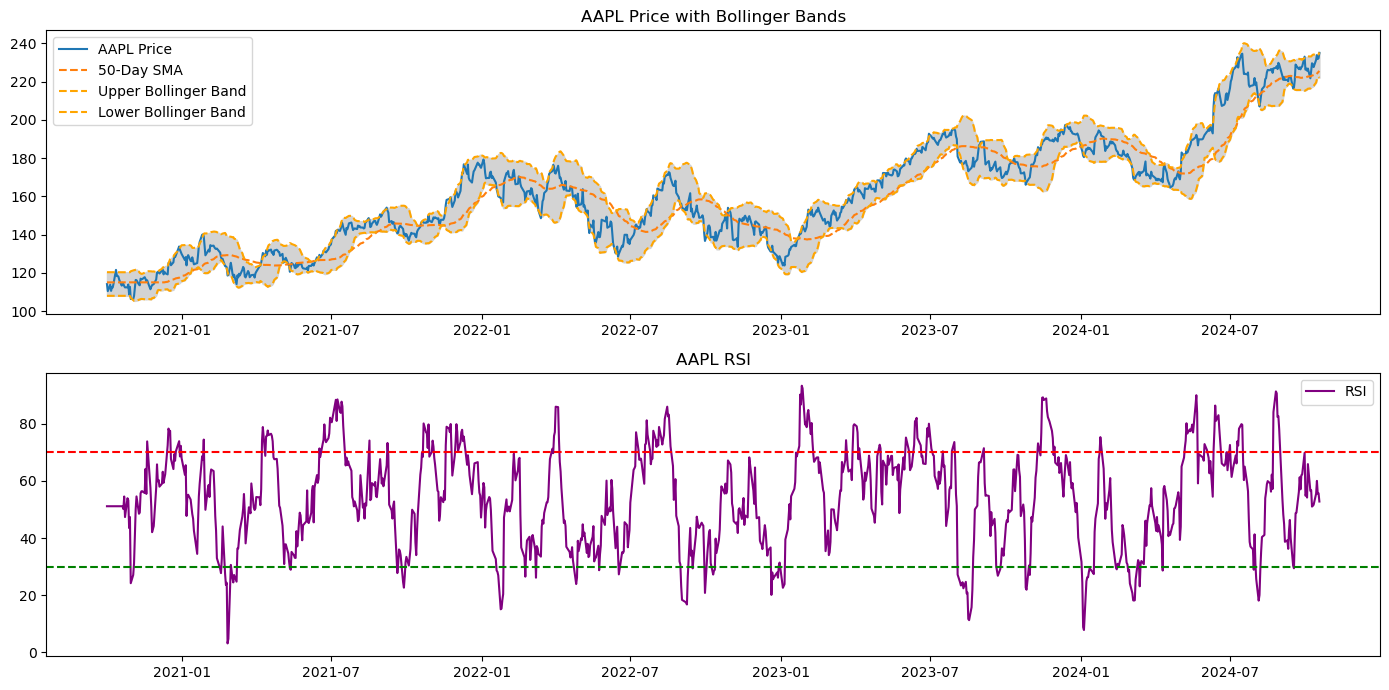

In [14]:
# Plot RSI and Bollinger Bands for a sample stock (e.g., AAPL)
ticker_sample = 'AAPL'
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data[ticker_sample], label=f'{ticker_sample} Price')
plt.plot(sma_50[ticker_sample], label='50-Day SMA', linestyle='--')
plt.plot(upper_band[ticker_sample], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(lower_band[ticker_sample], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(data.index, lower_band[ticker_sample], upper_band[ticker_sample], color='lightgray')
plt.legend()
plt.title(f'{ticker_sample} Price with Bollinger Bands')
plt.subplot(2, 1, 2)
plt.plot(rsi[ticker_sample], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f'{ticker_sample} RSI')
plt.tight_layout()
plt.show()

In [15]:
# Prepare data for plotting
ticker_sample = 'AAPL'
data_sample = data[[ticker_sample]].copy()
data_sample['SMA_50'] = sma_50[ticker_sample]
data_sample['SMA_100'] = sma_100[ticker_sample]
data_sample['SMA_200'] = sma_200[ticker_sample]
data_sample['RSI'] = rsi[ticker_sample]
data_sample['Support'] = support[ticker_sample]
data_sample['Resistance'] = resistance[ticker_sample]

# Plot
price_plot = data_sample.hvplot.line(y=[ticker_sample, 'SMA_50', 'SMA_100', 'SMA_200'], title=f'{ticker_sample} Price with Bollinger Bands, SMA, and Resistance Levels', ylabel='Price')
support_resistance_plot = data_sample.hvplot.line(y=['Support', 'Resistance'], line_dash='dashed', color=['green', 'red'])
rsi_plot = data_sample.hvplot.line(y='RSI', title=f'{ticker_sample} RSI', ylabel='RSI').opts(yformatter='%.0f') * hv.HLine(70).opts(color='red', line_dash='dashed') * hv.HLine(30).opts(color='green', line_dash='dashed')

(price_plot * support_resistance_plot + rsi_plot).cols(1)


:Layout
   .Overlay.I  :Overlay
      .NdOverlay.I  :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
      .NdOverlay.II :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [Date]   (RSI)
      .HLine.I  :HLine   [x,y]
      .HLine.II :HLine   [x,y]

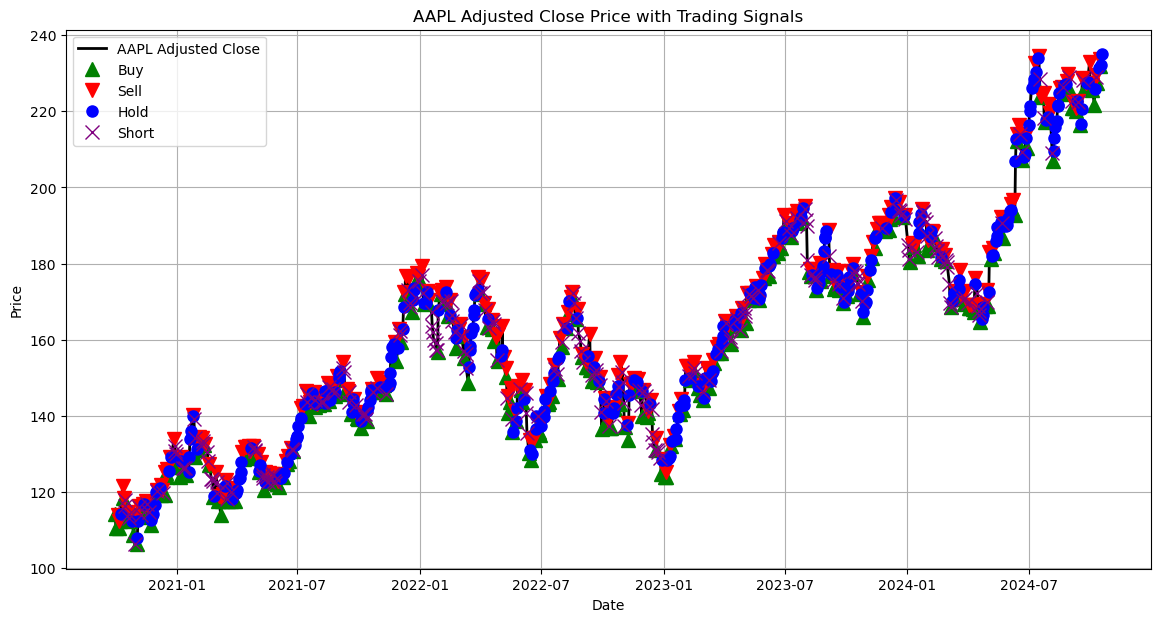

In [16]:
# %% Plot the trading signals for AAPL

ticker_sample = 'AAPL'

# Extract the price data and actions for AAPL
price_data = data[ticker_sample]
actions_aapl = actions[ticker_sample]

# Define marker styles for each action
marker_styles = {
    'buy': {'marker': '^', 'color': 'green', 'label': 'Buy', 'markersize': 10},
    'sell': {'marker': 'v', 'color': 'red', 'label': 'Sell', 'markersize': 10},
    'hold': {'marker': 'o', 'color': 'blue', 'label': 'Hold', 'markersize': 8},
    'short': {'marker': 'x', 'color': 'purple', 'label': 'Short', 'markersize': 10}
}

# Plot the stock price
plt.figure(figsize=(14, 7))
plt.plot(price_data, label=f'{ticker_sample} Adjusted Close', color='black', lw=2)

# Plot the markers for actions
for action, style in marker_styles.items():
    action_mask = actions_aapl == action
    plt.plot(price_data.index[action_mask], price_data[action_mask], 
             style['marker'], color=style['color'], label=style['label'], markersize=style['markersize'])

# Add titles, labels, and legends
plt.title(f'{ticker_sample} Adjusted Close Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# %% Plot the trading signals for AAPL using hvPlot

ticker_sample = 'AAPL'

# Prepare the price data and actions for AAPL
price_data = data[[ticker_sample]].copy()
price_data['Action'] = actions[ticker_sample]

# Define marker styles for each action
action_colors = {'buy': 'green', 'sell': 'red', 'hold': 'blue', 'short': 'purple'}

# Create a base line plot for the adjusted close price
price_plot = price_data.hvplot.line(
    y=ticker_sample, 
    title=f'{ticker_sample} Adjusted Close Price with Trading Signals',
    ylabel='Price', 
    line_width=2,
    height=400,
    width=800,
    legend=False
)

# Overlay the action markers
buy_markers = price_data[price_data['Action'] == 'buy'].hvplot.scatter(
    y=ticker_sample, marker='^', color=action_colors['buy'], size=10, label='Buy'
)
sell_markers = price_data[price_data['Action'] == 'sell'].hvplot.scatter(
    y=ticker_sample, marker='v', color=action_colors['sell'], size=10, label='Sell'
)
hold_markers = price_data[price_data['Action'] == 'hold'].hvplot.scatter(
    y=ticker_sample, marker='o', color=action_colors['hold'], size=6, label='Hold'
)
short_markers = price_data[price_data['Action'] == 'short'].hvplot.scatter(
    y=ticker_sample, marker='x', color=action_colors['short'], size=10, label='Short'
)

# Combine the price plot and the markers
interactive_plot = price_plot * buy_markers * sell_markers * hold_markers * short_markers

# Display the interactive plot with zoom functionality
interactive_plot.opts(legend_position='top_left')
interactive_plot


:Overlay
   .Curve.I       :Curve   [Date]   (AAPL)
   .Scatter.Buy   :Scatter   [Date]   (AAPL)
   .Scatter.Sell  :Scatter   [Date]   (AAPL)
   .Scatter.Hold  :Scatter   [Date]   (AAPL)
   .Scatter.Short :Scatter   [Date]   (AAPL)